In [3]:
import os
os.environ['NUMBAPRO_CUDALIB']=r"C:\Users\haoyu\Miniconda3\envs\py3gpu\Library\bin"

from pyculib import fft as pfft
from numba import cuda
import numpy as np
from skimage import measure as ms
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Load pattern

The image size is 651 by 597


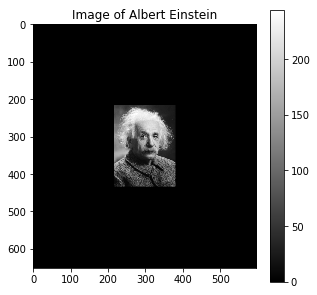

In [4]:
############################################################################################################################################
# Load the pattern
############################################################################################################################################
#Read in source image
source = plt.imread("../tests/samples/Albert_Einstein.jpg",format="jpg")

# Because the original image is too large downsample the image by a factor of 20
source = ms.block_reduce(source, (20,20), np.mean)

############################################################################################################################################
# Simulate the oversampling
############################################################################################################################################
## pad_len is the size of the support
pad_len = source.shape[0]
padded = np.pad(source, ((pad_len, pad_len),(pad_len, pad_len)), 'constant', 
                constant_values=((0,0),(0,0)))

#Show this figure
fig = plt.figure(figsize=(5,5))
plt.imshow(padded, cmap="gray")
plt.colorbar()
plt.title("Image of Albert Einstein")
print("The image size is %d by %d"%(padded.shape[0], padded.shape[1]))

# Get Diffraction intensity and the mask

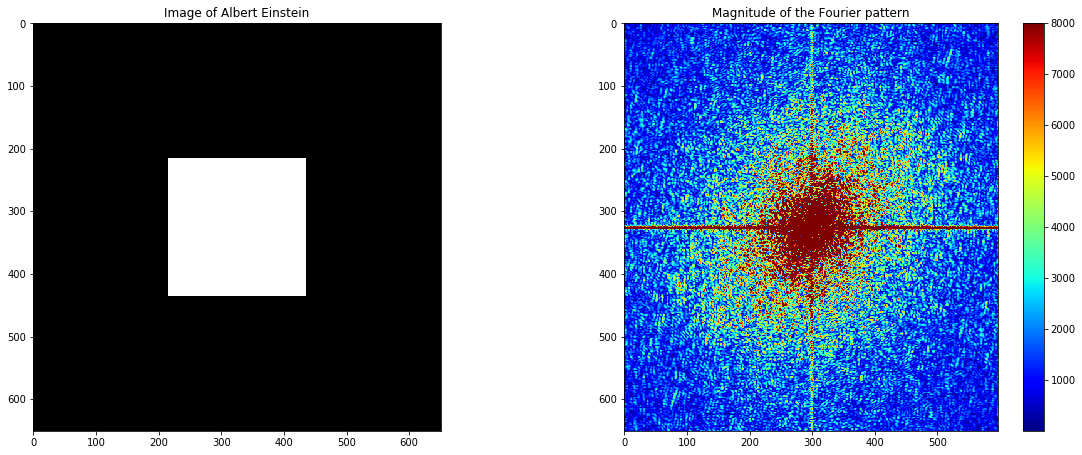

The image size is 651 by 651


In [17]:
# Calculate the fourier transformation
fourier_pattern = np.fft.ifftshift(np.fft.fft2(padded))

#simulate diffraction pattern
intensity = np.square(np.abs(fourier_pattern))

#keep track of where the image is vs the padding
length, width = padded.shape
mask = np.ones((pad_len+2,pad_len+2))
mask = np.pad(mask, ((pad_len-1, pad_len-1),(pad_len-1, pad_len-1)), 'constant', 
                constant_values=((0,0),(0,0)))


#Show this mask and the diffraction magnitude
magnitude = np.abs(fourier_pattern)

fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(20)
fig.set_figheight(7.5)

axes[0].imshow(mask, cmap='gray')
axes[0].set_title("Image of Albert Einstein")

tmp = axes[1].imshow(magnitude, cmap='jet', vmax=8e3)
axes[1].set_title("Magnitude of the Fourier pattern")

fig.colorbar(mappable=tmp, ax=axes[1])

plt.show()
print("The image size is %d by %d"%(mask.shape[0], mask.shape[1]))

# Initialize the calculation

In [ ]:
############################################################################################################################################
# Step 1: Initialize the variables
############################################################################################################################################
# Shift the magnitude
diffract = np.fft.fftshift(magnitude)

# Variable containg guessed phase to test.
new_guess = diffract * np.exp(1j * np.random.rand(length,width) * 2 * pi)

# number of iterations
r = 801

# step size parameter
beta = 0.8

############################################################################################################################################
# Step 2: Define variables to hold data during the calculation
############################################################################################################################################

# variable to hold the result multiplied with the magnitude constrain
maginitude_constrain_pattern = np.ones_like(diffract, dtype=np.complex64)

# variable to hold the result of modified_by_maginitude under inversely fourier transformation
ifft_pattern = np.ones_like(diffract, dtype=np.complex64)

# variable to hold the result of ifft_pattern modified by the real space constrain
real_constrain_ifft_pattern = np.ones_like(diffract, dtype=np.complex64)

# variable to store the previous guess
previous_guess = np.ones_like(diffract, dtype=np.complex64)

# Define useful functions

In [ ]:
@cuda.jit
def apply_real_space_constrain(shape_0, shape_1, beta, ifft_pattern, mask, modified_real_constrain_pattern, previous_guess):
    """Perform square matrix multiplication of C = A * B
    """
    # Get grid index
    i, j = cuda.grid(2)
    
    # Make sure that the grid is not out of the pattern
    if i < shape_0 and j < shape_1:
        
        # Apply the constrain
        if mask[i,j] & ifft_pattern[i,j]>0 :
            # Only in this situation, one does not need to modify the ifft_pattern
            modified_real_constrain_pattern[i,j] = ifft_pattern[i,j]
        else:
            modified_real_constrain_pattern[i,j] = previous_guess[i,j] - beta * ifft_pattern[i,j]

In [4]:
@cuda.jit
def apply_mask(frame, mask):
    i, j = cuda.grid(2)
    frame[i, j] *= mask[i, j]

# … skipping some array setup here: frame is a 720x1280 numpy array
frame = np.zeros((1280, 1280))
frame[234:500, 234:500] = 1

mask = np.ones_like(frame, dtype=np.complex64)
threads_per_block = 64
blocks = 24

out = np.empty_like(mask, dtype=np.complex64)
gpu_temp = cuda.to_device(out)  # make GPU array
gpu_mask = cuda.to_device(mask)  # make GPU array

pyculib.fft.fft(frame.astype(np.complex64), gpu_temp)  # implied host->device
apply_mask[blocks, threads_per_block](gpu_temp, gpu_mask)  # all on device
raw = pyculib.fft.ifft(gpu_temp, out)  # implied device->host

In [5]:
import matplotlib.pyplot as plt

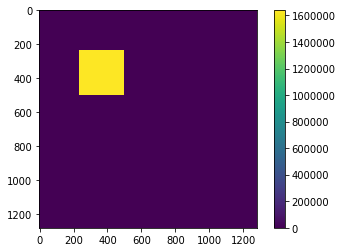

In [6]:
plt.imshow(raw.real)
plt.colorbar()
plt.show()